# HW4

### NAME: Yuhao Wang
### UNI: yw3204

### Problem 1

1. $d^2(x, x') = <x, x> - 2<x, x'> + <x', x'>$

2. $d_K^2(x, x') = <\phi(x), \phi(x)> - 2<\phi(x), \phi(x')> + <\phi(x'), \phi(x')> = K(x, x)-2K(x, x')+K(x', x')$

3. It calculates the Euclidean distance in the feature space w.r.t the feature mapping $\phi$.

### Problem 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

In [54]:
# load data
credit_data = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/Credit.csv")
credit_data = credit_data.drop(credit_data.columns[[0]], axis = 1)

# coding dummy variables
credit_data["Gender"] = [0 if i == "Female" else 1 for i in credit_data["Gender"]]
credit_data["Student"] = [0 if i == "No" else 1 for i in credit_data["Student"]]
credit_data["Married"] = [0 if i == "No" else 1 for i in credit_data["Married"]]

credit_data["Ethnicity1"] = 0
credit_data = credit_data[['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'Gender', 
             'Student', 'Married', 'Ethnicity', 'Ethnicity1', 'Balance']]
credit_data["Ethnicity1"] = [1 if i == "Asian" else 0 for i in credit_data["Ethnicity"]]
credit_data["Ethnicity"] = [1 if i == "Caucasian" else 0 for i in credit_data["Ethnicity"]]

# credit_data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Ethnicity1,Balance
0,14.891,3606,283,2,34,11,1,0,1,1,0,333
1,106.025,6645,483,3,82,15,0,1,1,0,1,903
2,104.593,7075,514,4,71,11,1,0,0,0,1,580
3,148.924,9504,681,3,36,11,0,0,0,0,1,964
4,55.882,4897,357,2,68,16,1,0,1,1,0,331


### Problem 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import KFold
import seaborn as sns

%matplotlib inline
plt.style.use("ggplot")

In [2]:
# load data
x5 = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/train.5.txt", header = None)
x6 = pd.read_csv("/Users/apple/Desktop/semester_2/4.Stat_ML/hw/hw4/train.6.txt", header = None)

y5 = np.repeat(-1, x5.shape[0])
y6 = np.repeat(1, x6.shape[0])

x = pd.concat([x5, x6], ignore_index=True)
y = np.concatenate([y5, y6])

np.random.seed(0)
ind = np.random.choice(len(y), int(0.2*len(y)), replace=False)
test_ind = [i in ind for i in range(len(y))]
train_ind = [i not in ind for i in range(len(y))]

test_x = x.loc[test_ind, :]
test_x = test_x.reset_index(drop=True)
test_y = y[test_ind, ]

train_x = x.loc[train_ind, :]
train_x = train_x.reset_index(drop=True)
train_y = y[train_ind, ]

In [ ]:
# cross validation error
def cv(x, y, m, k=4):
    kf = KFold(n_splits=k)
    err = []
    
    for train_ind, val_ind in kf.split(x):
        x_train, x_val = x.loc[train_ind], x.loc[val_ind]
        y_train, y_val = y[train_ind], y[val_ind]
        m.fit(x_train, y_train)
        err.append(sum(m.predict(x_val) != y_val))
    
    cv_err = np.sum(err)/len(y)
    return cv_err

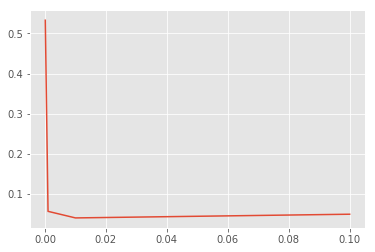

In [55]:
# 1. (a)
# margin parameters
Cs = [1e-4, 1e-3, 1e-2, 0.05, 1e-1]

CV_errs = []

for i in Cs:
    tmp_svm = svm.SVC(kernel="linear", C = i)
    CV_errs.append(cv(train_x, train_y, tmp_svm))
    
plt.plot(Cs, CV_errs)
plt.show()

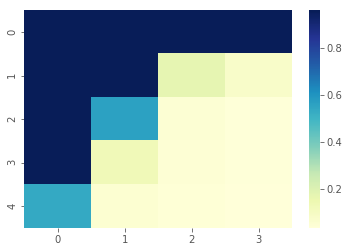

In [51]:
# 1. (b)

Cs = [0.01, 0.1, 0.5, 1, 5]
gammas = [1e-5, 1e-4, 1e-3, 0.003]

CV_mat = [[] for i in range(len(Cs))]

for i in range(len(Cs)):
    for j in range(len(gammas)):
        tmp_svm = svm.SVC(C = Cs[i], gamma = gammas[j])
        CV_mat[i].append(cv(train_x, train_y, tmp_svm))
    
sns.heatmap(CV_mat, cmap="YlGnBu")
plt.show()

In [ ]:
# 2.
